In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import time
import datetime

from importlib import reload
from instruments import instek3032
from instruments import yoko7651
from instruments import zvk
from instruments import fsva

%cd S:\analysis\python\notebooks\tunable-filter

# -------------- SOME USEFUL FUNCTIONS

def get_max_peaks(amps, f_list):
    if f_list.ndim == 1 : 
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[i, np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")

def get_band_pass_position(amps_dB, f_list, cutoff = 3):
    if f_list.ndim == 1 : 
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
        return band_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[i, np.min(pass_band)], f_list[i, np.max(pass_band)]
        return band_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")
    
def get_band_pass_single_trace(amps_dB, f_list, cutoff = 3):
    max_val = np.max(amps_dB)
    pass_band = np.nonzero(amps_dB >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
    band_freqs = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
    return band_freqs, max_val

def theoretical_peak_position(V):
    return (38e9/10)*V + 2e9

S:\analysis\python\notebooks\tunable-filter


# Characterizing the MICRO LAMBDA WIRELESS tunable filter

## 1. Verifying rough peak position as a function of voltage
### i. Getting data

Instrument initialized.
VISA resource: GPIB1::20::INSTR
VISA instrument released (GPIB1::20::INSTR).
Instrument initialized.
VISA resource: GPIB1::3::INSTR
VISA instrument released (GPIB1::3::INSTR).
Expected duration of measurement : 6829 s


Filename ? (or Enter to cancel, or Space+Enter for freq_dep_study):   


VISA instrument released (GPIB1::20::INSTR).
VISA instrument released (GPIB1::3::INSTR).


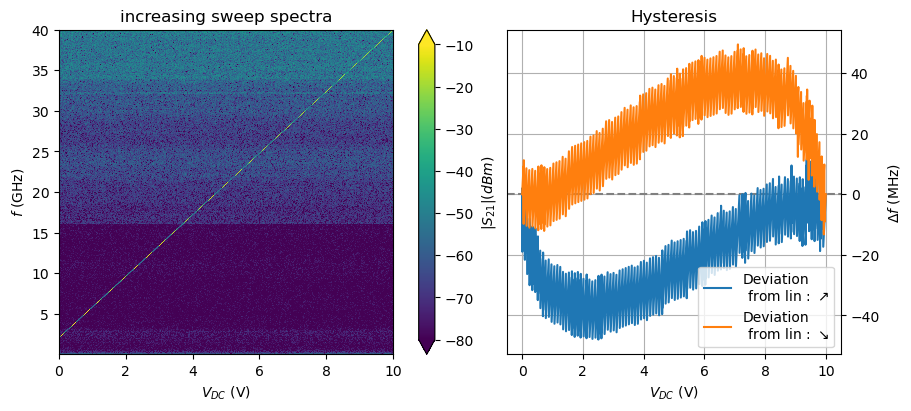

In [44]:
reload(zvk)
reload(yoko7651)
# reload(instek3032)

vna = zvk.Zvk("GPIB1::20::INSTR")
# instek = instek3032.Instek3032("ASRL5::INSTR")
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')

# ------------------------ PARAMETERS
n_voltage_points = 2001
n_sweep_points = 2001
f_start = 10e6
f_stop  = 40e9

saving_frequency = 100

bias_values = np.linspace(0, 10, n_voltage_points)
f_values = np.linspace(f_start, f_stop, n_sweep_points)

amps_increasing_V = np.zeros((n_voltage_points, n_sweep_points))
phases_increasing_V = np.zeros_like(amps_increasing_V)

amps_decreasing_V = np.zeros_like(amps_increasing_V)
phases_decreasing_V = np.zeros_like(amps_increasing_V)

z_increasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')
z_decreasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')



# ------------------------ INSTRUMENT SETUP (if needed)

# instek.dc_offset = 0
# instek.load = "INF"
# instek.unit = "VPP"
# instek.apply_waveform("DC")

yoko.source_voltage()
yoko.voltage(0)
yoko.range_voltage(12)
yoko.output(True)


vna.freq_start_stop = [f_start, f_stop]
vna.sweep_points = n_sweep_points
vna.power = -15 #dBm
vna.averaging = 0
vna.sweep_count = 1
vna.bandwidth = 10e3

# ------------------------ LOADING DATA 
filename = 'freq_dep_study'
wavename = filename
comment = 'no time dependence study for now'

tracename = 'CH1DATA'
S_parameter = 'S21'
ch = 1

when = datetime.datetime.now()
meta = {
    'center': vna.center_freq,
    'span': vna.freq_span,
    'start': vna.start_freq,
    'stop': vna.stop_freq,
    'nb_points': vna.sweep_points,
    'sweep_count': vna.sweep_count,
    "sweep_duration":vna.sweep_duration,
    "averaging": vna.averaging,
    'VBW': vna.bandwidth,
    'power': vna.power,
    'S_parameter': S_parameter,
    'datetime': when
}

single_sweep_time = 1.1*vna.sweep_duration
total_time = 2*single_sweep_time*(n_voltage_points + 0.1)

print(f"Expected duration of measurement : {total_time:.0f} s")

filename_final = input(f'Filename ? (or Enter to cancel, or Space+Enter for {filename}): ')
if filename_final == '':
    print("measurement cancelled.")
    pass
else:
    if filename_final == ' ':
        filename_final = filename + when.strftime('%Y%m%d-%Hh%Mmin%Ss')
        
    ######## INCREASING V PASS
    
    for i, v in enumerate(bias_values):
        
        # instek.dc_offset = v
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_increasing_V[i, :] = z
        
        phases_increasing_V[i, :] = np.angle(z)
        amps_increasing_V[i, :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
        

    ######## DECREASING V PASS
    
    for i, v in enumerate(np.flip(bias_values)):
        
        # instek.dc_offset = v
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_decreasing_V[-(i+1), :] = z 
        
        phases_decreasing_V[-(i+1), :] = np.angle(z)
        amps_decreasing_V[-(i+1), :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    f_max_increasing, _ = get_max_peaks(amps_increasing_V, f_values)
    f_max_decreasing, _ = get_max_peaks(amps_decreasing_V, f_values)

    line = (f_max_increasing[-1] - f_max_increasing[0])/(bias_values[-1] - bias_values[0]) * bias_values + f_max_increasing[0]

    fig = plt.figure(dpi = 100, figsize = (9, 4), constrained_layout = True)
    gs = fig.add_gridspec(1, 2)
    ax_l = fig.add_subplot(gs[:, 0])
    ax_r = fig.add_subplot(gs[:, 1])

    im_l_i = ax_l.imshow(amps_increasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
    #im_l_d = ax_l.imshow(amps_decreasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
    fig.colorbar(im_l_i, ax = ax_l, extend = 'both', alpha = 1, label = r'$\left| S_{21}\right| (dBm)$')
    ax_l.set_title("increasing sweep spectra")
    # ax_l.plot(bias_values, f_max_increasing/1e9, label = 'Increasing V')
    # ax_l.plot(bias_values, f_max_decreasing/1e9, label = "Decreasing V")
    # ax_l.legend()
    ax_l.set_xlabel(r"$V_{DC}$ (V)")
    ax_l.set_ylabel(r"$f$ (GHz)")



    ax_r.set_xlabel(r"$V_{DC}$ (V)")
    ax_r.set_ylabel(r"$\Delta f$ (MHz)")
    ax_r.yaxis.tick_right()
    ax_r.yaxis.set_label_position("right")
    ax_r.set_title("Hysteresis")
    ax_r.axhline(color = 'gray', ls = '--')
    ax_r.plot(bias_values, (f_max_increasing - line)/1e6, label = "Deviation\n from lin : " r"$\nearrow$")
    ax_r.plot(bias_values, (f_max_decreasing - line)/1e6, label = "Deviation\n from lin : " r"$\searrow$")
    ax_r.legend()
    ax_r.grid(True)
    
    fig.savefig(filename_final + '.png')

del vna
# del instek
del yoko

### ii. Loading data from previous run

In [5]:
with np.load("freq_dep_study20220427-18h41min39s.npz", allow_pickle = True) as npzfile:
    f_values = npzfile["f_values"]
    bias_values = npzfile["bias_values"]
    z_increasing = npzfile['z_increasing_V']
    z_decreasing = npzfile['z_decreasing_V']
    meta = npzfile['meta']

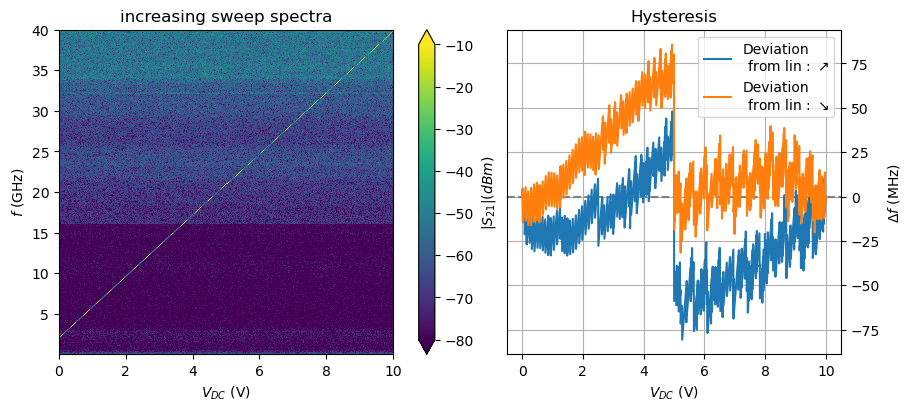

In [32]:
%matplotlib inline

amps_increasing_V = 20*np.log10(np.abs(z_increasing))
amps_decreasing_V = 20*np.log10(np.abs(z_decreasing))
f_start, f_stop = f_values[0], f_values[-1]

f_max_increasing, _ = get_max_peaks(amps_increasing_V, f_values)
f_max_decreasing, _ = get_max_peaks(amps_decreasing_V, f_values)

line = (f_max_increasing[-1] - f_max_increasing[0])/(bias_values[-1] - bias_values[0]) * bias_values + f_max_increasing[0]

fig = plt.figure(dpi = 100, figsize = (9, 4), constrained_layout = True)
gs = fig.add_gridspec(1, 2)
ax_l = fig.add_subplot(gs[:, 0])
ax_r = fig.add_subplot(gs[:, 1])

im_l_i = ax_l.imshow(amps_increasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
#im_l_d = ax_l.imshow(amps_decreasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
fig.colorbar(im_l_i, ax = ax_l, extend = 'both', alpha = 1, label = r'$\left| S_{21}\right| (dBm)$')
ax_l.set_title("increasing sweep spectra")
# ax_l.plot(bias_values, f_max_increasing/1e9, label = 'Increasing V')
# ax_l.plot(bias_values, f_max_decreasing/1e9, label = "Decreasing V")
# ax_l.legend()
ax_l.set_xlabel(r"$V_{DC}$ (V)")
ax_l.set_ylabel(r"$f$ (GHz)")



ax_r.set_xlabel(r"$V_{DC}$ (V)")
ax_r.set_ylabel(r"$\Delta f$ (MHz)")
ax_r.yaxis.tick_right()
ax_r.yaxis.set_label_position("right")
ax_r.set_title("Hysteresis")
ax_r.axhline(color = 'gray', ls = '--')
ax_r.plot(bias_values, (f_max_increasing - line)/1e6, label = "Deviation\n from lin : " r"$\nearrow$")
ax_r.plot(bias_values, (f_max_decreasing - line)/1e6, label = "Deviation\n from lin : " r"$\searrow$")
ax_r.legend()
ax_r.grid(True)
    


## 2. Characterizing with better resolution
### i. Getting the data

Instrument initialized.
VISA resource: GPIB1::20::INSTR
Instrument initialized.
VISA resource: GPIB1::3::INSTR
Expected duration of measurement : 15 s


Filename ? (or Enter to cancel, or Space+Enter for fine_freq_dep_study):   


VISA instrument released (GPIB1::20::INSTR).
VISA instrument released (GPIB1::3::INSTR).


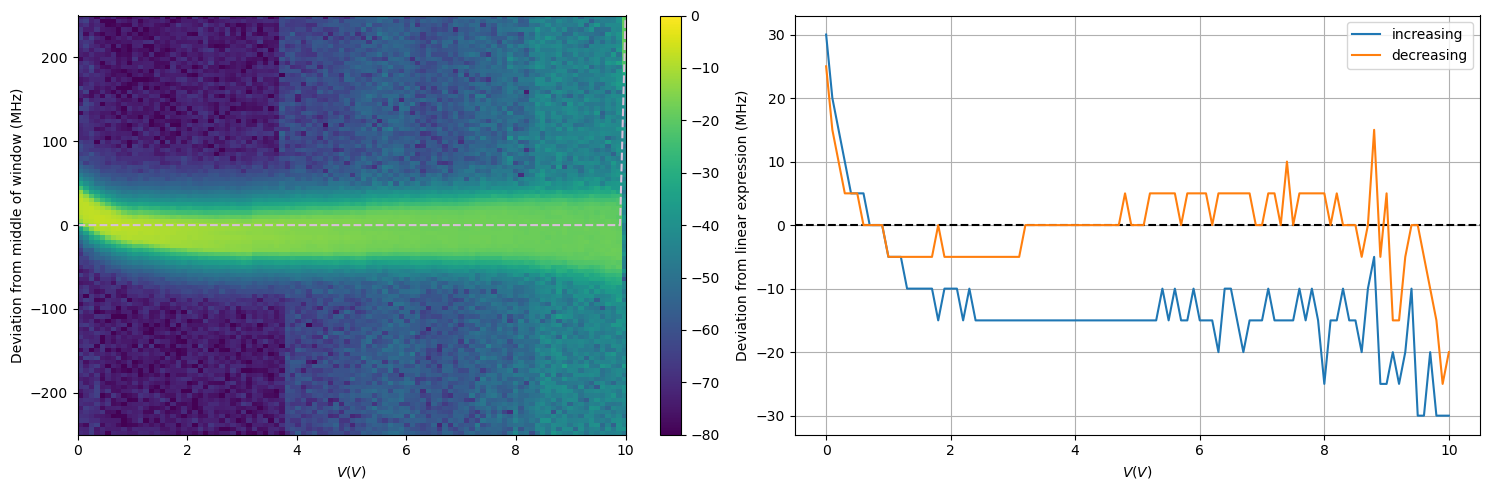

In [82]:
reload(zvk)
# reload(instek3032)

vna = zvk.Zvk("GPIB1::20::INSTR")
# instek = instek3032.Instek3032("ASRL5::INSTR")
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')


# ------------------------ A USEFUL FUNCTION

def freq_window(V, delta):
    """Gives the freq window to give  to the VNA for input voltage V and window width delta (delta in Hz)"""
    if V <= (10/38e9)*(40e9 - 2e9 - delta/2) :
        return np.array([-delta/2, delta/2]) + (38e9/10)*V + 2e9
    else : 
        return np.array([40e9 - delta, 40e9])

# ------------------------ PARAMETERS
n_voltage_points = 101
n_sweep_points = 101
f_start = 10e6
f_stop  = 40e9
window_width = 500e6

saving_frequency = 100

bias_values = np.linspace(0, 10, n_voltage_points)
f_values = np.array([freq_window(v, window_width) for v in bias_values])

amps_increasing_V = np.zeros((n_voltage_points, n_sweep_points))
phases_increasing_V = np.zeros_like(amps_increasing_V)

amps_decreasing_V = np.zeros_like(amps_increasing_V)
phases_decreasing_V = np.zeros_like(amps_increasing_V)

z_increasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')
z_decreasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')



# ------------------------ INSTRUMENT SETUP (if needed)

# instek.dc_offset = 0
# instek.load = "INF"
# instek.unit = "VPP"
# instek.apply_waveform("DC")

yoko.source_voltage()
yoko.voltage(0)
yoko.range_voltage(12)
yoko.output(True)


vna.freq_start_stop = f_values[0, :]
vna.sweep_points = n_sweep_points
vna.power = -20 #dBm
vna.averaging = 0
vna.sweep_count = 1
vna.bandwidth = 10e3

# ------------------------ LOADING DATA 
filename = 'fine_freq_dep_study'
wavename = filename
comment = 'put your comment here'

tracename = 'CH1DATA'
S_parameter = 'S21'
ch = 1

when = datetime.datetime.now()
meta = {
    'freq_values' : f_values,
    'nb_points': vna.sweep_points,
    'sweep_count': vna.sweep_count,
    "sweep_duration":vna.sweep_duration,
    "averaging": vna.averaging,
    'VBW': vna.bandwidth,
    'power': vna.power,
    'S_parameter': S_parameter,
    'datetime': when
}

single_sweep_time = 1.1*vna.sweep_duration
total_time = 2*single_sweep_time*(n_voltage_points + 0.1)

print(f"Expected duration of measurement : {total_time:.0f} s")

filename_final = input(f'Filename ? (or Enter to cancel, or Space+Enter for {filename}): ')
if filename_final == '':
    print("measurement cancelled.")
    pass
else:
    if filename_final == ' ':
        filename_final = filename + when.strftime('%Y%m%d-%Hh%Mmin%Ss')
        
    ######## INCREASING V PASS
    
    for i, v in enumerate(bias_values):
        vna.freq_start_stop = f_values[i, :]
        
        # instek.dc_offset = v
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_increasing_V[i, :] = z
        
        phases_increasing_V[i, :] = np.angle(z)
        amps_increasing_V[i, :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
        

    ######## DECREASING V PASS
    
    for i, v in enumerate(np.flip(bias_values)):
        vna.freq_start_stop = f_values[-(i+1), :]
        
        # instek.dc_offset = v
        # yoko.voltage(0)
        # time.sleep(1e-3)
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_decreasing_V[-(i+1), :] = z 
        
        phases_decreasing_V[-(i+1), :] = np.angle(z)
        amps_decreasing_V[-(i+1), :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    full_f_values = np.array([np.linspace(f_values[v, 0], f_values[v, 1], meta["nb_points"]) for v, _ in enumerate(bias_values)])

    amps_increasing_V = 20*np.log10(abs(z_increasing_V))
    amps_decreasing_V = 20*np.log10(abs(z_decreasing_V))

    true_lin_position = np.linspace(2e9, 40e9, len(bias_values))
    relative_lin_position = (true_lin_position - np.mean(f_values, axis = 1))

    f_max_increasing, _ = get_max_peaks(amps_increasing_V, full_f_values)
    f_max_decreasing, _ = get_max_peaks(amps_decreasing_V, full_f_values)

    fig, axs = plt.subplots(1, 2, dpi = 100, figsize = (15, 5), tight_layout = True)
    ax_l, ax_r = axs

    im = ax_l.imshow(np.maximum(amps_increasing_V, amps_decreasing_V).T, aspect = 'auto', origin = 'lower', extent = [bias_values[0], bias_values[-1], (-window_width/2)*1e-6, 1e-6*window_width/2], interpolation = 'none', vmin = -80, vmax = 0, cmap = 'viridis')
    # im_r = ax_l.imshow(amps_decreasing_V.T, aspect = 'auto', origin = 'lower',alpha = 0.5, extent = [bias_values[0], bias_values[-1], (-window_width/2)*1e-6, 1e-6*window_width/2], interpolation = 'none', vmin = -80, vmax = 0, cmap = 'viridis')
    fig.colorbar(im, ax = ax_l)
    # fig.colorbar(im_r, ax = ax)
    # ax_l.vlines(5, (-window_width/2)*1e-6, 1e-6*window_width/2 )
    ax_l.plot(bias_values, relative_lin_position*1e-6 , ls = '--', color = 'thistle')

    ax_l.set_xlabel(r"$V(V)$")
    ax_l.set_ylabel('Deviation from middle of window (MHz)')

    ax_r.axhline(color = 'k', ls = '--')
    ax_r.plot(bias_values, (f_max_increasing - true_lin_position )*1e-6, label = 'increasing' )
    ax_r.plot(bias_values, (f_max_decreasing - true_lin_position )*1e-6, label = 'decreasing' )
    ax_r.legend()
    ax_r.grid(True)
    ax_r.set_xlabel(r"$V(V)$")
    ax_r.set_ylabel('Deviation from linear expression (MHz)')
    
    fig.savefig(filename_final + '.png')

del vna
del yoko
# del instek

In [84]:
with np.load("fine_freq_dep_study20220428-21h50min22s.npz", allow_pickle = True) as npzfile:
    f_values = npzfile["f_values"]
    bias_values = npzfile["bias_values"]
    z_increasing = npzfile['z_increasing_V']
    z_decreasing = npzfile['z_decreasing_V']
    meta = npzfile['meta'].item()


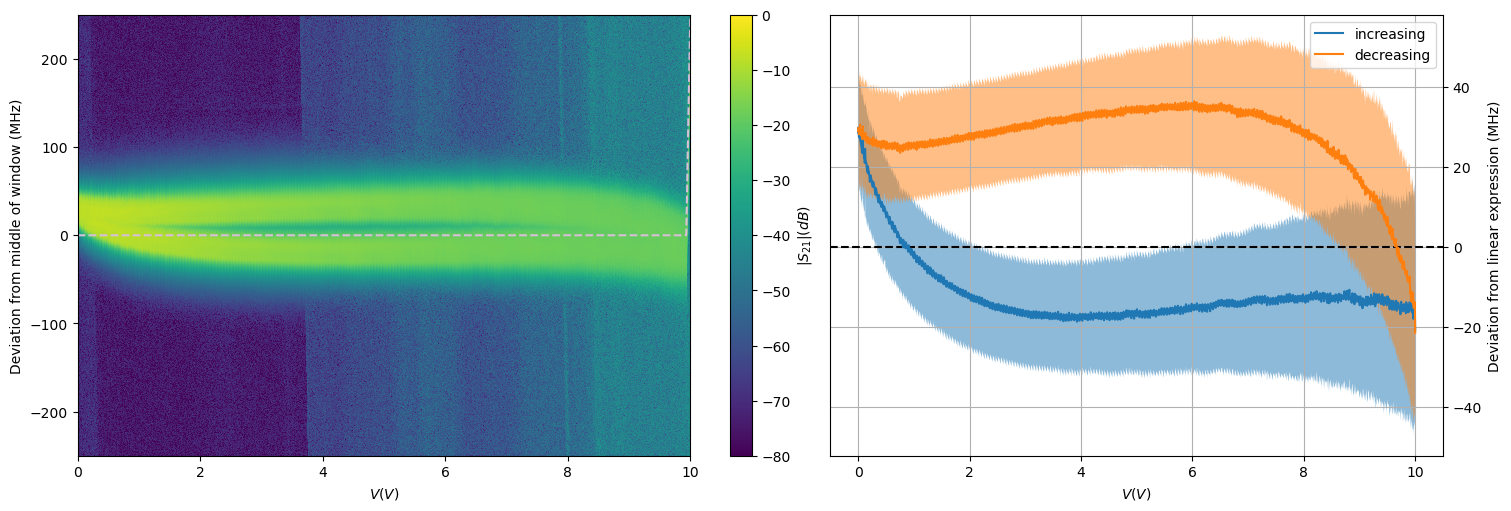

In [89]:
from matplotlib.legend_handler import HandlerTuple
full_f_values = np.array([np.linspace(f_values[v, 0], f_values[v, 1], meta["nb_points"]) for v, _ in enumerate(bias_values)])

amps_increasing_V = 20*np.log10(abs(z_increasing))
amps_decreasing_V = 20*np.log10(abs(z_decreasing))

true_lin_position = np.linspace(2e9, 40e9, len(bias_values))
relative_lin_position = (true_lin_position - np.mean(f_values, axis = 1))

# f_max_increasing, _ = get_max_peaks(amps_increasing_V, full_f_values)
# f_max_decreasing, _ = get_max_peaks(amps_decreasing_V, full_f_values)

band_increasing, _ = get_band_pass_position(amps_increasing_V, full_f_values)
band_delta_increasing = (band_increasing.T - true_lin_position.T).T

band_decreasing, _ = get_band_pass_position(amps_decreasing_V, full_f_values)
band_delta_decreasing = (band_decreasing.T - true_lin_position.T).T

fig, axs = plt.subplots(1, 2, dpi = 100, figsize = (15, 5), constrained_layout = True)
ax_l, ax_r = axs

im = ax_l.imshow(np.maximum(amps_increasing_V, amps_decreasing_V).T, aspect = 'auto', origin = 'lower', extent = [bias_values[0], bias_values[-1], (-window_width/2)*1e-6, 1e-6*window_width/2], interpolation = 'none', vmin = -80, vmax = 0, cmap = 'viridis')
# im_r = ax_l.imshow(amps_decreasing_V.T, aspect = 'auto', origin = 'lower',alpha = 0.5, extent = [bias_values[0], bias_values[-1], (-window_width/2)*1e-6, 1e-6*window_width/2], interpolation = 'none', vmin = -80, vmax = 0, cmap = 'viridis')
fig.colorbar(im, ax = ax_l, label = r'$\left|S_{21}\right| (dB)$')
# fig.colorbar(im_r, ax = ax)
# ax_l.vlines(5, (-window_width/2)*1e-6, 1e-6*window_width/2 )
ax_l.plot(bias_values, relative_lin_position*1e-6 , ls = '--', color = 'thistle')

ax_l.set_xlabel(r"$V(V)$")
ax_l.set_ylabel('Deviation from middle of window (MHz)')

ax_r.axhline(color = 'k', ls = '--')
# ax_r.plot(bias_values, (f_max_increasing - true_lin_position )*1e-6, label = 'increasing' )
# ax_r.plot(bias_values, (f_max_decreasing - true_lin_position )*1e-6, label = 'decreasing' )
l1 = ax_r.plot(bias_values, np.mean(band_delta_increasing, axis = 1)*1e-6, label = 'increasing' )
l1_shade = ax_r.fill_between(bias_values, band_delta_increasing[:, 0]*1e-6, band_delta_increasing[:, 1]*1e-6, alpha = 0.5 )
l2 = ax_r.plot(bias_values, np.mean(band_delta_decreasing, axis = 1)*1e-6, label = 'decreasing' )
l2_shade = ax_r.fill_between(bias_values, band_delta_decreasing[:, 0]*1e-6, band_delta_decreasing[:, 1]*1e-6, alpha = 0.5 )

ax_r.legend()
ax_r.grid(True)
ax_r.yaxis.tick_right()
ax_r.yaxis.set_label_position("right")
ax_r.set_xlabel(r"$V(V)$")
ax_r.set_ylabel('Deviation from linear expression (MHz)')

fig.savefig("complete_fine_freq_dep_study20220428-21h50min22s.png")

## 3. Trying to make a kind of "transition matrix" for $\Delta f$, the error in ferquency 

In [6]:
reload(zvk)
# reload(instek3032)

vna = zvk.Zvk("GPIB1::20::INSTR")
# instek = instek3032.Instek3032("ASRL5::INSTR")
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')


# ------------------------ A USEFUL FUNCTION

def freq_window(V, delta):
    """Gives the freq window to give  to the VNA for input voltage V and window width delta (delta in Hz)"""
    if V <= (10/38e9)*(40e9 - 2e9 - delta/2) :
        return np.array([-delta/2, delta/2]) + (38e9/10)*V + 2e9
    else : 
        return np.array([40e9 - delta, 40e9])

# ------------------------ PARAMETERS
n_voltage_points = 301
n_sweep_points = 101
f_start = 10e6
f_stop  = 40e9
window_width = 500e6

saving_frequency = 100

bias_values = np.linspace(0, 10, n_voltage_points)

spectra_after_jumps = np.ones((n_voltage_points, n_voltage_points, n_sweep_points), dtype = 'complex')
pass_bands_after_jumps = np.ones((n_voltage_points, n_voltage_points, 2))
center_freq_after_jumps = np.ones((n_voltage_points, n_voltage_points))


f_values = np.array([freq_window(v, window_width) for v in bias_values]) # no need to make this 2D, it only depends on the arrival value of the voltage when jumping


# ------------------------ INSTRUMENT SETUP (if needed)

# instek.dc_offset = 0
# instek.load = "INF"
# instek.unit = "VPP"
# instek.apply_waveform("DC")

yoko.source_voltage()
yoko.voltage(0)
yoko.range_voltage(12)
yoko.output(True)


vna.freq_start_stop = f_values[0, :]
vna.sweep_points = n_sweep_points
vna.power = -20 #dBm
vna.averaging = 0
vna.sweep_count = 1
vna.bandwidth = 10e3

# ------------------------ LOADING DATA 
filename = 'transition_offset_study'
wavename = filename
comment = 'Preliminary run for testing'

tracename = 'CH1DATA'
S_parameter = 'S21'
ch = 1

when = datetime.datetime.now()
meta = {
    'freq_values' : f_values,
    'nb_points': vna.sweep_points,
    'sweep_count': vna.sweep_count,
    "sweep_duration":vna.sweep_duration,
    "averaging": vna.averaging,
    'VBW': vna.bandwidth,
    'power': vna.power,
    'S_parameter': S_parameter,
    'datetime': when
}

single_sweep_time = 1.1*vna.sweep_duration
total_time = 2*single_sweep_time*(n_voltage_points + 0.1)**2

print(f"Expected duration of measurement : {total_time:.0f} s")

filename_final = input(f'Filename ? (or Enter to cancel, or Space+Enter for {filename}): ')
if filename_final == '':
    print("measurement cancelled.")
    pass
else:
    if filename_final == ' ':
        filename_final = filename + when.strftime('%Y%m%d-%Hh%Mmin%Ss')
        
    t_beginning = time.time()
        
    for k in range(1, n_voltage_points) : # k varies from 1 to N-1
        for n_0 in range(k) : #n_O goes from 0 to k-1
            max_n = (n_voltage_points - 1 - n_0)//k
            
            if max_n == 0 : 
                continue
            
            yoko.voltage(0)
            yoko.voltage(bias_values[n_0])
            
            # forward pass : n_O -> max value possible with this jump length
            for n in range(1, max_n + 1):
                voltage_origin_index = (n - 1)*k + n_0 # index of voltage we're jumping from
                voltage_destination_index = n*k + n_0 # index of voltage we're jumping to 
                # print(f"from {voltage_origin_index} = {bias_values[voltage_origin_index]} to {voltage_destination_index} = {bias_values[voltage_destination_index]} ")
                
                vna.freq_start_stop = f_values[voltage_destination_index, :]
                
                yoko.voltage(bias_values[voltage_destination_index])
                time.sleep(10e-3)
                
                vna.trigger()
                time.sleep(single_sweep_time)
                
                while vna.busy() :
                    time.sleep(100e-3)
                
                _, z = vna.get_data(trace = tracename)
                
                spectra_after_jumps[voltage_origin_index, voltage_destination_index, :] = z
            
            # backwards pass : max value -> back to n_0
            for n in range(1, max_n + 1):
                voltage_origin_index = (max_n - (n - 1))*k + n_0 # index of voltage we're jumping from
                voltage_destination_index = (max_n - n)*k + n_0 # index of voltage we're jumping to 
                # print(f"from {voltage_origin_index} = {bias_values[voltage_origin_index]} to {voltage_destination_index} = {bias_values[voltage_destination_index]} ")
                
                vna.freq_start_stop = f_values[voltage_destination_index, :]
                
                yoko.voltage(bias_values[voltage_destination_index])
                time.sleep(10e-3)
                
                vna.trigger()
                time.sleep(single_sweep_time)
                
                while vna.busy() :
                    time.sleep(100e-3)
                
                _, z = vna.get_data(trace = tracename)
                
                spectra_after_jumps[voltage_origin_index, voltage_destination_index, :] = z
    
    
    np.savez(filename_final, f_values=f_values, bias_values = bias_values, spectra_after_jumps = spectra_after_jumps, meta=meta, comment=comment)

    t_end = time.time()
    
    duration = t_end - t_beginning
    print(f"Measurement took {duration:.0f} s")
    yoko.voltage(0)
    
    full_f_values = np.array([np.linspace(j[0], j[1], n_sweep_points) for j in f_values])
    amps_after_jumps = 20*np.log10(np.abs(spectra_after_jumps))

    pass_bands_after_jumps = np.array([[get_band_pass_single_trace(amps_after_jumps[i, j, :], full_f_values[j, :])[0] for j in range(n_voltage_points)]for i in range(n_voltage_points)])
    center_freqs_after_jumps = np.mean(pass_bands_after_jumps, axis = 2)
    freq_deltas = np.array([[center_freqs_after_jumps[i, j] - theoretical_peak_position(V) for j, V in enumerate(bias_values)] for i, _ in enumerate(bias_values)])

    np.fill_diagonal(freq_deltas, 0)

    np.savez(filename_final, f_values=f_values, bias_values = bias_values, spectra_after_jumps = spectra_after_jumps, freq_deltas = freq_deltas, meta=meta, comment=comment)
    
    fig, ax = plt.subplots(dpi = 100)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    im = ax.imshow(freq_deltas*1e-6, extent = [bias_values[0], bias_values[-1],bias_values[-1], bias_values[0]], cmap = 'RdBu_r', vmin = -50, vmax = 50)
    fig.colorbar(im, ax = ax, label = r"$\Delta f (MHz)$")
    fig.savefig(filename_final + '.png')
    
del vna
del yoko
# del instek

Instrument initialized.
VISA resource: GPIB1::20::INSTR
Instrument initialized.
VISA resource: GPIB1::3::INSTR
Expected duration of measurement : 13824 s


Filename ? (or Enter to cancel, or Space+Enter for transition_offset_study):   


KeyboardInterrupt: 

In [136]:
amps_after_jumps.dtype

dtype('float64')

In [94]:
import pyvisa

rm = pyvisa.ResourceManager()
rm.list_resources()

('TCPIP0::192.168.164.65::inst0::INSTR',
 'TCPIP0::192.168.164.23::inst0::INSTR',
 'TCPIP0::192.168.164.23::hislip0::INSTR',
 'TCPIP0::192.168.164.18::hislip0::INSTR',
 'TCPIP0::192.168.164.18::inst0::INSTR',
 'ASRL1::INSTR',
 'ASRL5::INSTR',
 'ASRL10::INSTR',
 'GPIB0::13::INSTR',
 'GPIB0::24::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::6::INSTR',
 'GPIB1::12::INSTR',
 'GPIB1::20::INSTR',
 'GPIB1::3::INSTR',
 'GPIB1::4::INSTR',
 'GPIB1::5::INSTR',
 'GPIB1::6::INSTR',
 'GPIB1::8::INSTR',
 'GPIB2::8::INSTR',
 'USB0::0x0957::0xB318::MY55380016::0::INSTR',
 'USB0::0x168C::0x218A::0000212925::0::INSTR',
 'USB0::0x1AB1::0x0642::DG1ZA184350307::0::INSTR',
 'GPIB1::20::0::INSTR')

In [95]:
from instruments import yoko7651
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')

Instrument initialized.
VISA resource: GPIB1::3::INSTR


In [149]:
del vna
del yoko

VISA instrument released (GPIB1::3::INSTR).
